In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Data Preparation for Machine Learning
Extracting and Cleaning Data

In [15]:
df = pd.read_json("../real_estate_for_ML.json")
df.dropna(inplace=True)
statistic_df = pd.json_normalize(df["statistic"])

df = pd.concat([df, statistic_df], axis=1)
df.drop(columns=["statistic"], inplace=True)

# Data cleaning
df = df.transpose()
df.columns = df.iloc[0]
df = df[1:]
last_7_columns_values = df.iloc[:, -7:].values
destination_columns = df.iloc[:, -14:-7]
# Assign the values to the destination columns
for i, column in enumerate(destination_columns.columns):
    df[column] = last_7_columns_values[:, i]

df = df.iloc[:, :-7]

df.replace(r"\s+", "", regex=True, inplace=True)
df = df.astype("int64")
df["mean_prices"] = df.mean(axis=1)

df.head()

name,ЖК Квартал Краківський,ЖК HydroPark DeLuxe,ЖК Manhattan Up,ЖК Парковий маєток,ЖК Містечко Козацьке,ЖК Козацький,ЖК Millennium,ЖК Опришівська Слобода,ЖК Квартал Віденський,ЖК Comfort Park,ЖК Паркова Алея,Житловий район Manhattan,ЖК Family Plaza,Житловий район „Княгинин“,mean_prices
2021-06,462,468,421,433,341,434,446,433,853,313,495,440,507,498,467.428571
2021-07,472,476,443,452,341,446,477,436,855,399,499,450,520,510,484.000000
2021-08,499,476,443,473,370,458,480,437,855,408,499,462,537,511,493.428571
2021-09,504,496,469,473,370,460,480,437,876,408,499,456,541,508,498.357143
2021-10,524,491,467,481,370,473,512,441,905,413,527,477,575,526,513.000000


# Also Preparing Data Frame for future Prophet model

In [16]:
df_for_prophet = df
df_for_prophet.index = pd.to_datetime(df.index)

# Reset index to create a common index column with IDs
df_for_prophet.reset_index(inplace=True)
df_for_prophet = df[["index", "mean_prices"]].copy()

df_for_prophet.rename(columns={"index": "ds", "mean_prices": "y"}, inplace=True)
df_for_prophet.head()

name,ds,y
0,2021-06-01,467.428571
1,2021-07-01,484.000000
2,2021-08-01,493.428571
3,2021-09-01,498.357143
4,2021-10-01,513.000000


# Model training

In [17]:
# A set of signs (features) that are used to predict the price
x = np.arange(len(df)).reshape(-1, 1)

# Target variable
y = df["mean_prices"]

# Separation of data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Model initialization and training
model = LinearRegression()
model.fit(x_train, y_train)

# Making predictions
predictions = model.predict(x_test)

# Checking model accuracy
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 825.6754821005394


As we can see, Mean Squared Error is pretty good, so it means that my model's predictions are very close to the actual values. In that time I picked good strategy ;)

# Making plot for comparing Actual and Predicted Prices

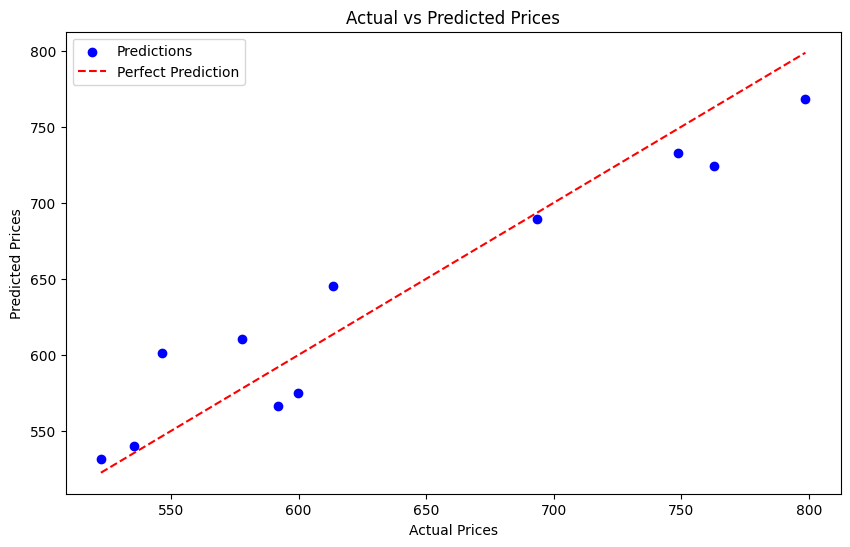

In [18]:
predictions = pd.DataFrame(predictions)
predictions["mean_price"] = predictions.mean(axis=1)

# Create a plot to visualize Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions["mean_price"].values, color="blue", label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red", label="Perfect Prediction")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.show()

# Making predictions for the next 1,5 year using Linear Regression model

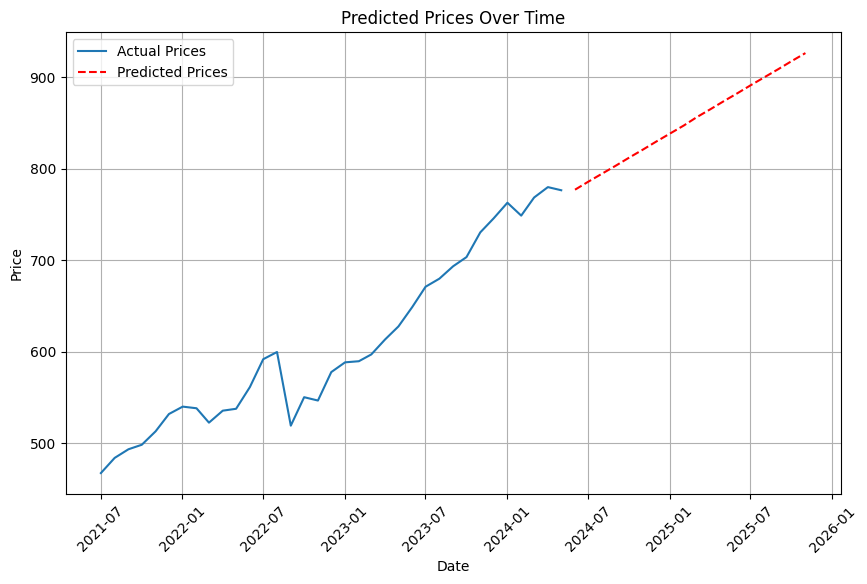

In [19]:
# Creating next rows for prediction
next_rows = np.arange(len(df), len(df) + 18).reshape(-1, 1)

# Use the trained model to predict the prices for the future
future_predictions = model.predict(next_rows)

# Define the start date as the current date
start_date = pd.to_datetime("today")

# Define the end date as 18 months from the start date
end_date = start_date + pd.DateOffset(months=18)

# Define previous dates
previous_start_date = start_date - pd.DateOffset(months=35)
previous_dates = pd.date_range(start=previous_start_date, end=start_date, freq="MS")

# Generate the list of future dates
future_dates = pd.date_range(start=start_date, end=end_date, freq="MS")

# Create a plot to visualize the predicted prices over time
plt.figure(figsize=(10, 6))
plt.plot(previous_dates, y[:-1], label="Actual Prices")
plt.plot(future_dates, future_predictions, 'r--', label="Predicted Prices")
plt.title("Predicted Prices Over Time")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

On this plot, we observe the results of our Linear Regression predictions. The forecast indicates a steady upward trend in prices over time. While the model's performance appears satisfactory, the plot presents a straightforward visualization of the predicted price growth.

# Making predictions using Facebook Prophet model

13:39:58 - cmdstanpy - INFO - Chain [1] start processing
13:39:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\User\PycharmProjects\py-scrape-and-analisys-of-real-estate-market\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\User\PycharmProjects\py-scrape-and-analisys-of-real-estate-market\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\User\AppData\Local\Temp\ipykernel_7784\315256107.

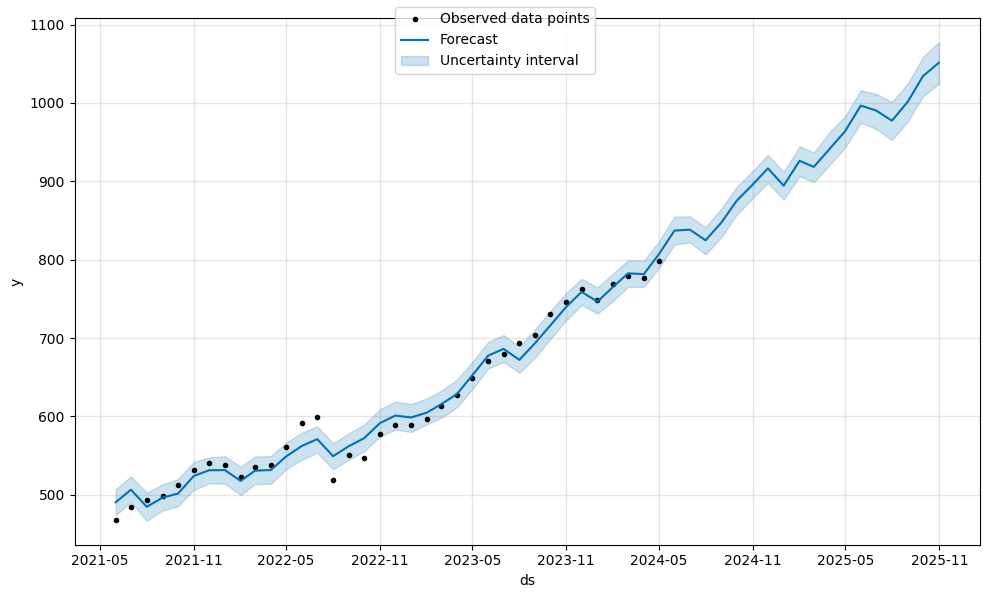

In [20]:
# Model initialization
m = Prophet()
m.fit(df_for_prophet)

# Making predictions for next 1,5 year
future = m.make_future_dataframe(periods=18, freq="ME")
forecast = m.predict(future)

# Create a plot to visualize the predicted prices over time
fig1 = m.plot(forecast)
fig1.legend(loc="upper center")
fig1.show()

Looking at this plot generated by Prophet model, we can observe the forecasted price trends. The model predicts a consistent increase in prices over time. This plot effectively illustrates the projected growth.